### Importing required modules

In [119]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset,random_split,DataLoader
import torch.nn.functional as F
import torch.nn as nn

import pickle

### Loading data

In [120]:
file_path = 'C:\Data\Study\Ai_adventures\Projects\Deep _Learning\Android-Malware Detection\outputs\processed_data.pkl'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

In [121]:
X = data["features"]
y = data["targets"]

- Creating Tesnor dataset

In [122]:
def Dataset(X,y):
    features = X.to_numpy()
    labels = y.to_numpy()

    features_tensor = torch.tensor(features)
    labels_numeric = np.where(labels=="MALWARE",1,0).reshape(-1,1)
    labels_tensor = torch.tensor(labels_numeric,dtype=torch.float32)

    data = TensorDataset(features_tensor,labels_tensor)
    return data

In [123]:
data = Dataset(X,y)
data

- Splitting data

In [124]:
train_ds,val_ds = random_split(data,[len(data)-10000,10000])

- Data Loaders

In [125]:
batch_size = 10000
train_dl = DataLoader(train_ds,batch_size,shuffle=True)
val_dl = DataLoader(val_ds,batch_size)

In [126]:
for xb,yb in train_dl:
    print(xb,yb)
    break

tensor([[5.3000e+01, 2.4334e+04, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [8.0000e+01, 8.5179e+07, 7.0000e+00,  ..., 0.0000e+00, 8.5000e+07,
         8.5000e+07],
        [5.3000e+01, 5.0203e+04, 4.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [5.3000e+01, 2.3782e+04, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.4300e+02, 5.5312e+05, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [8.0000e+01, 4.3190e+04, 9.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], dtype=torch.float64) tensor([[0.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])


In [127]:
for batch in train_dl:
    features,labels = batch
    print(features.shape,labels)
    break

torch.Size([10000, 78]) tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]])


- Model building 

In [128]:
def accuracy(outputs,actuals):
    _,preds = torch.max(outputs,dim=1)
    acc = torch.tensor(torch.sum(preds==actuals).item()/len(preds))
    return acc

class LogisticRegression(nn.Module):
    def training_step(self,batch):
        features,labels = batch
        outputs = self(features)
        loss = F.cross_entropy(outputs,labels.squeeze().long())
        return loss
    def validation_step(self,batch):
        features,labels = batch
        outputs = self(features)
        loss = F.cross_entropy(outputs,labels.squeeze().long())
        acc = accuracy(outputs,labels.squeeze().long())
        return {"val loss":loss.detach(),"val acc":acc}
    def validation_epoch_end(self,outputs):
        batch_loss = [x["val loss"] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x["val acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val loss":epoch_loss.item(),"val acc":epoch_acc.item()}
    def epoch_end(self, epoch_num, results, fit_one_cycle=False):
        if fit_one_cycle:
            print("Epoch [{}], last_lr: {:.5f}, train loss: {:.4f}, val loss: {:.4f}, val acc: {:.4f}".format(
                epoch_num, results['lrs'][-1], results['train loss'], results['val loss'], results['val acc']))
        else:
            print("Epoch[{}] -> TRAIN LOSS : {:.4f} | VALIDATION LOSS : {:.4f} | VALIDATION ACC : {:.4f}".format(
                epoch_num, results["train loss"], results["val loss"], results["val acc"]))
    @torch.no_grad()
    def evaluate(self,val_dl):
        self.eval()
        outputs = [self.validation_step(batch) for batch in val_dl]
        return self.validation_epoch_end(outputs)

In [129]:
def linear_block(in_channels, out_channels):
    layers = [
        nn.Linear(in_channels, out_channels),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(inplace=True)
    ]
    return nn.Sequential(*layers)

class NetworkArchitecture(LogisticRegression):
    def __init__(self):
        super().__init__()
        self.linear1 = linear_block(len(train_ds[0][0]), 50)
        self.linear2 = linear_block(50, 25)
        self.linear3 = linear_block(25, 10)
        self.classifier = nn.Linear(10, 2)
    
    def forward(self, xb):
        out = self.linear1(xb.float())
        out = self.linear2(out)
        out = self.linear3(out)
        out = self.classifier(out)
        return out   

In [130]:
model_f = NetworkArchitecture()
model_foc = NetworkArchitecture()
model_f

NetworkArchitecture(
  (linear1): Sequential(
    (0): Linear(in_features=78, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (linear2): Sequential(
    (0): Linear(in_features=50, out_features=25, bias=True)
    (1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (linear3): Sequential(
    (0): Linear(in_features=25, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=10, out_features=2, bias=True)
)

- Training using fit

In [131]:
def fit(epoch_num,lr,model,train_dl,val_dl,optim_func):
    optimizer = optim_func(model.parameters(),lr)
    history = []
    for epoch in range(epoch_num):
        train_losses = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        results = model.evaluate(val_dl)
        results["train loss"] = torch.stack(train_losses).mean()
        model.epoch_end(epoch,results)
        history.append(results)
    return history

In [132]:
model_f.evaluate(val_dl)

{'val loss': 265554.6875, 'val acc': 0.3012999892234802}

In [133]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [134]:
history = fit(num_epochs, lr, model_f, train_dl, val_dl, opt_func)

Epoch[0] -> TRAIN LOSS : 19631.1406 | VALIDATION LOSS : 161.4915 | VALIDATION ACC : 0.6809
Epoch[1] -> TRAIN LOSS : 122.0913 | VALIDATION LOSS : 18.5089 | VALIDATION ACC : 0.6622
Epoch[2] -> TRAIN LOSS : 78.4797 | VALIDATION LOSS : 1.5896 | VALIDATION ACC : 0.6776
Epoch[3] -> TRAIN LOSS : 21.6174 | VALIDATION LOSS : 2.6711 | VALIDATION ACC : 0.6818
Epoch[4] -> TRAIN LOSS : 22.2341 | VALIDATION LOSS : 0.8661 | VALIDATION ACC : 0.6752
Epoch[5] -> TRAIN LOSS : 15.4082 | VALIDATION LOSS : 1.4194 | VALIDATION ACC : 0.6827
Epoch[6] -> TRAIN LOSS : 15.2598 | VALIDATION LOSS : 1.0542 | VALIDATION ACC : 0.6830
Epoch[7] -> TRAIN LOSS : 31.9850 | VALIDATION LOSS : 1.3621 | VALIDATION ACC : 0.6828
Epoch[8] -> TRAIN LOSS : 13.6224 | VALIDATION LOSS : 0.7875 | VALIDATION ACC : 0.6816
Epoch[9] -> TRAIN LOSS : 21.0487 | VALIDATION LOSS : 2.2339 | VALIDATION ACC : 0.6830
Epoch[10] -> TRAIN LOSS : 8.8901 | VALIDATION LOSS : 0.6735 | VALIDATION ACC : 0.6796
Epoch[11] -> TRAIN LOSS : 3.1922 | VALIDATION L

In [135]:
def plot_accuracies(history):
    accuracies = [x['val acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

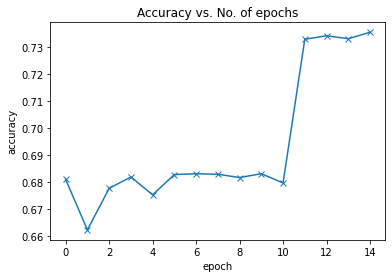

In [136]:
plot_accuracies(history)

In [137]:
def plot_losses(history):
    train_losses = [x.get('train loss').detach().numpy() for x in history]
    val_losses = [x['val loss'].detach().numpy() if isinstance(x['val loss'], torch.Tensor) else x['val loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

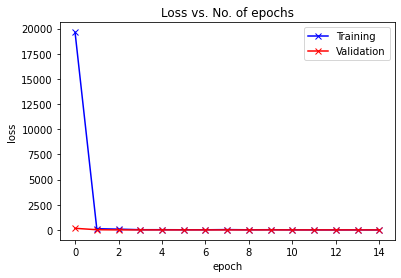

In [138]:
plot_losses(history)

- Training using fit one cycle

In [139]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs): 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
        result = model.evaluate(val_loader)
        result['train loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [140]:
history_foc = [model_foc.evaluate(val_dl)]
history_foc

[{'val loss': 102478.1875, 'val acc': 0.3165999948978424}]

In [141]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [142]:
%%time
history_foc += fit_one_cycle(epochs, max_lr, model_foc,
                         train_dl, val_dl, 
                         grad_clip = grad_clip, 
                         weight_decay = weight_decay, 
                         opt_func = opt_func)

Epoch[0] -> TRAIN LOSS : 0.4786 | VALIDATION LOSS : 0.3848 | VALIDATION ACC : 0.9136
Epoch[1] -> TRAIN LOSS : 0.2991 | VALIDATION LOSS : 0.2256 | VALIDATION ACC : 0.9494
Epoch[2] -> TRAIN LOSS : 0.1663 | VALIDATION LOSS : 0.1587 | VALIDATION ACC : 0.9544
Epoch[3] -> TRAIN LOSS : 0.1595 | VALIDATION LOSS : 0.1741 | VALIDATION ACC : 0.9508
Epoch[4] -> TRAIN LOSS : 0.1522 | VALIDATION LOSS : 0.1809 | VALIDATION ACC : 0.9536
Epoch[5] -> TRAIN LOSS : 0.1531 | VALIDATION LOSS : 0.1472 | VALIDATION ACC : 0.9582
Epoch[6] -> TRAIN LOSS : 0.1433 | VALIDATION LOSS : 0.1686 | VALIDATION ACC : 0.9558
Epoch[7] -> TRAIN LOSS : 0.1438 | VALIDATION LOSS : 0.1607 | VALIDATION ACC : 0.9549
Epoch[8] -> TRAIN LOSS : 0.1406 | VALIDATION LOSS : 0.1332 | VALIDATION ACC : 0.9585
Epoch[9] -> TRAIN LOSS : 0.1357 | VALIDATION LOSS : 0.1381 | VALIDATION ACC : 0.9573
Epoch[10] -> TRAIN LOSS : 0.1339 | VALIDATION LOSS : 0.1282 | VALIDATION ACC : 0.9593
Epoch[11] -> TRAIN LOSS : 0.1260 | VALIDATION LOSS : 0.1212 | VA

In [143]:
def plot_accuracies(history):
    accuracies = [x['val acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

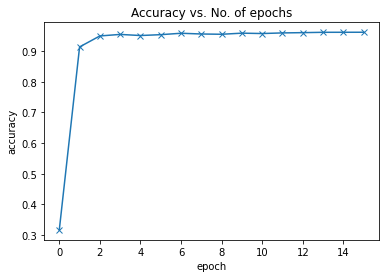

In [144]:
plot_accuracies(history_foc)

In [145]:
def plot_losses(history):
    train_losses = [x.get('train loss') for x in history]
    val_losses = [x['val loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

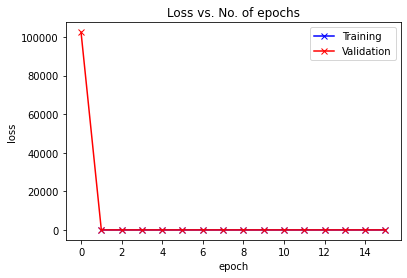

In [146]:
plot_losses(history_foc)

In [147]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

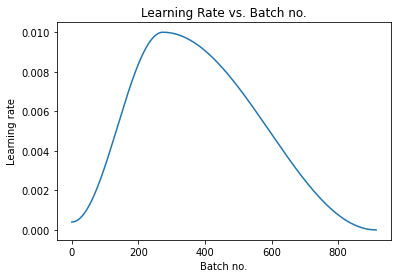

In [148]:
plot_lrs(history_foc)

- Saving the w&b

In [149]:
folder_path = 'C:/Data/Study/Ai_adventures/Projects/Deep _Learning/Android-Malware Detection/models/'
torch.save(model_foc.state_dict(), folder_path + 'model_weights.pth')